In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, norm

np.random.seed(1)


In [3]:
from google.colab import files
uploaded = files.upload()


Saving synthetic_data.csv to synthetic_data.csv


In [4]:

# Load the data
data_all = pd.read_csv("synthetic_data.csv")
data_all['schoolid'] = data_all['schoolid'].astype('category')

DF = data_all.drop(columns=['schoolid'])
school_id = data_all['schoolid'].cat.codes3

school_mat = pd.get_dummies(data_all['schoolid'], drop_first=False).to_numpy()
school_size = school_mat.sum(axis=0)

In [5]:
# Logistic regression for propensity score
w_lm = LogisticRegression().fit(data_all.drop(columns=['Z', 'schoolid']), data_all['Z'])
print(w_lm)

W = DF['Z'].to_numpy()
Y = DF['Y'].to_numpy()
X_raw = DF.drop(columns=['Z', 'Y'])


LogisticRegression()


In [6]:
X_ps = data_all.drop(columns=['Z', 'schoolid'])
Z = data_all['Z']
w_lm = LogisticRegression().fit(X_ps, Z)
w_hat = w_lm.predict_proba(X_ps)[:, 1]
print(w_lm)

W = DF['Z'].to_numpy()
Y = DF['Y'].to_numpy()
X_raw = DF.drop(columns=['Z', 'Y'])

LogisticRegression()


In [7]:
# One-hot encode categorical variables
enc = OneHotEncoder(drop='first')
C1_exp = enc.fit_transform(X_raw[['C1']]).toarray()
XC_exp = enc.fit_transform(X_raw[['XC']]).toarray()
X = np.hstack([X_raw.drop(columns=['C1', 'XC']).to_numpy(), C1_exp, XC_exp])

In [8]:
# Grow forests for Y and W
Y_forest = RandomForestRegressor()
Y_forest.fit(X, Y)
Y_hat = Y_forest.predict(X)

W_forest = RandomForestRegressor()
W_forest.fit(X, W)
W_hat = W_forest.predict(X)

In [9]:
# Estimate treatment effect using decision trees
cf_raw = DecisionTreeRegressor()
cf_raw.fit(X, Y - Y_hat * W_hat)
tau_hat = cf_raw.predict(X)


In [10]:
# Estimate ATE
ATE = np.mean(tau_hat)
ATE_se = np.std(tau_hat) / np.sqrt(len(tau_hat))
print(f"95% CI for the ATE: {round(ATE, 3)} +/- {round(norm.ppf(0.975) * ATE_se, 3)}")


95% CI for the ATE: -0.089 +/- 0.007


In [11]:
# Omnibus tests for heterogeneity
high_effect = tau_hat > np.median(tau_hat)
ate_high = np.mean(tau_hat[high_effect])
ate_low = np.mean(tau_hat[~high_effect])
se_high = np.std(tau_hat[high_effect]) / np.sqrt(sum(high_effect))
se_low = np.std(tau_hat[~high_effect]) / np.sqrt(sum(~high_effect))
print(f"95% CI for difference in ATE: {round(ate_high - ate_low, 3)} +/- {round(norm.ppf(0.975) * np.sqrt(se_high**2 + se_low**2), 3)}")


95% CI for difference in ATE: 0.558 +/- 0.01


In [12]:
# Formal test for X1 and X2
dr_score = tau_hat + W / W_hat * (Y - Y_hat - (1 - W_hat) * tau_hat) - (1 - W) / (1 - W_hat) * (Y - Y_hat + W_hat * tau_hat)
school_score = school_mat.T @ dr_score / school_size

school_X1 = school_mat.T @ X[:, X_raw.columns.get_loc("X1")] / school_size
high_X1 = school_X1 > np.median(school_X1)
print(ttest_ind(school_score[high_X1], school_score[~high_X1]))

school_X2 = school_mat.T @ X[:, X_raw.columns.get_loc("X2")] / school_size
high_X2 = school_X2 > np.median(school_X2)
print(ttest_ind(school_score[high_X2], school_score[~high_X2]))

school_X2_levels = pd.cut(school_X2, bins=[-np.inf, np.quantile(school_X2, 1/3), np.quantile(school_X2, 2/3), np.inf])
anova_result = pd.DataFrame({"score": school_score, "level": school_X2_levels}).groupby("level").mean()
print(anova_result)


TtestResult(statistic=nan, pvalue=nan, df=nan)
TtestResult(statistic=nan, pvalue=nan, df=nan)
                 score
level                 
(-inf, -0.305]     NaN
(-0.305, 0.505]    NaN
(0.505, inf]       NaN


<ipython-input-12-da3ea4763d33>:2: RuntimeWarning: invalid value encountered in divide
  dr_score = tau_hat + W / W_hat * (Y - Y_hat - (1 - W_hat) * tau_hat) - (1 - W) / (1 - W_hat) * (Y - Y_hat + W_hat * tau_hat)


In [13]:
# Formal test for S3
school_score_XS3_high = school_mat.T @ (dr_score * (X[:, X_raw.columns.get_loc("S3")] >= 6)) / school_mat.T @ (X[:, X_raw.columns.get_loc("S3")] >= 6)
school_score_XS3_low = school_mat.T @ (dr_score * (X[:, X_raw.columns.get_loc("S3")] < 6)) / school_mat.T @ (X[:, X_raw.columns.get_loc("S3")] < 6)

plt.scatter(school_score_XS3_low, school_score_XS3_high)
plt.show()
print(ttest_ind(school_score_XS3_high, school_score_XS3_low))

ValueError: operands could not be broadcast together with shapes (76,) (76,10391) 

/usr/local/lib/python3.10/dist-packages/matplotlib/axes/_axes.py:6762: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/usr/local/lib/python3.10/dist-packages/matplotlib/axes/_axes.py:6763: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


ValueError: autodetected range of [nan, nan] is not finite

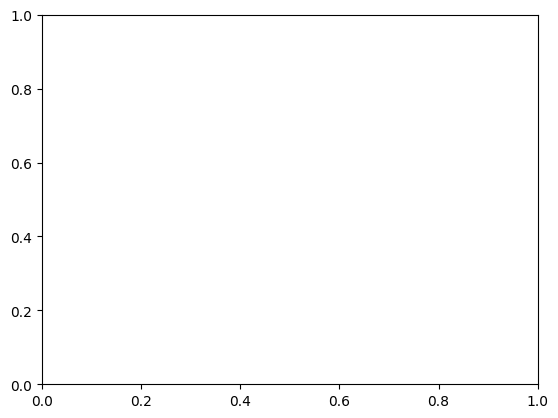

In [14]:
# Look at school-wise heterogeneity
plt.hist(school_score, bins=20)
plt.xlabel("School Treatment Effect Estimate")
plt.show()

# Re-check ATE... sanity check only
ate_hat = school_score.mean()
se_hat = np.sqrt(school_score.var() / (len(school_score) - 1))
print(f"{round(ate_hat, 3)} +/- {round(1.96 * se_hat, 3)}")

# Look at variation in propensity scores
DF = pd.DataFrame(X, columns=X_raw.columns)
DF['W_hat'] = W_hat

sns.boxplot(x="S3", y="W_hat", data=DF)
plt.show()

# Analysis ignoring clusters
cf_noclust = DecisionTreeRegressor()
cf_noclust.fit(X, Y - Y_hat * W_hat)
tau_hat_noclust = cf_noclust.predict(X)

ATE_noclust = np.mean(tau_hat_noclust)
ATE_se_noclust = np.std(tau_hat_noclust) / np.sqrt(len(tau_hat_noclust))
print(f"95% CI for the ATE: {round(ATE_noclust, 3)} +/- {round(norm.ppf(0.975) * ATE_se_noclust, 3)}")

# Cross-validation for cluster-robust estimates
nfold = 5
school_levels = np.unique(school_id)
cluster_folds = np.random.randint(0, nfold, len(school_levels))

tau_hat_crossfold = np.full(len(Y), np.nan)
for foldid in range(nfold):
    infold = np.isin(school_id, school_levels[cluster_folds == foldid])
    cf_fold = DecisionTreeRegressor()
    cf_fold.fit(X[~infold], Y[~infold] - Y_hat[~infold] * W_hat[~infold])
    pred_fold = cf_fold.predict(X[infold])
    tau_hat_crossfold[infold] = pred_fold

cf_noclust_cpy = tau_hat_crossfold
Rloss = np.mean(((Y - Y_hat) - tau_hat * (W - W_hat))**2)
Rloss_noclust = np.mean(((Y - Y_hat) - tau_hat_noclust * (W - W_hat))**2)
Rloss_crossfold = np.mean(((Y - Y_hat) - tau_hat_crossfold * (W - W_hat))**2)

print(Rloss_noclust - Rloss, Rloss_crossfold - Rloss)

anova_result = pd.DataFrame({"score": dr_score, "school_id": school_id}).groupby("school_id").mean()
print(anova_result)

# Analysis without fitting the propensity score
cf_noprop = DecisionTreeRegressor()
cf_noprop.fit(X, Y - np.mean(W) * Y_hat)
tau_hat_noprop = cf_noprop.predict(X)

ATE_noprop = np.mean(tau_hat_noprop)
ATE_se_noprop = np.std(tau_hat_noprop) / np.sqrt(len(tau_hat_noprop))
print(f"95% CI for the ATE: {round(ATE_noprop, 3)} +/- {round(norm.ppf(0.975) * ATE_se_noprop, 3)}")
